In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf
from geopy.distance import geodesic
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from collections import defaultdict

# Projekt - Predykcja zanieczyszczenia PM2.5 - Anna Kaniowska 407334

## Część 1 - Przygotowanie danych i inżynieria cech

### Przegląd danych

In [2]:
df = pd.read_excel("data/2019_PM25_1g.xlsx", header=1, index_col=0)

In [3]:
df = df.drop(
    ["Wskaźnik", "Czas uśredniania", "Jednostka", "Kod stanowiska"]
)  # PM2.5, 1g, ug/m3, <Kod stacji>-PM2.5-1g
df.index = df.index.rename("Date")
df.index = pd.to_datetime(df.index)
df.head()

,DsDusznikMOB,DsJaworMOB,DsJelGorOgin,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpMogiNowMOB,KpToruDziewu,KpWloclOkrze,LbLubObywate,...,SlBielPartyz,SlKatoKossut,SlZlotPotLes,WmElbBazynsk,WmGoldUzdrowMOB,WmOlsPuszkin,WpKaliSawick,ZpSzczAndr01,ZpSzczBudzWosMOB,ZpSzczPils02
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 01:00:00,33.4053,51.3878,118.773,102.09,107.061,64.1177,NaN,24.003,51.317,56.091,...,110.199,76.7306,26.3444,34.3706,14.9449,40.9183,75.2,NaN,NaN,73.935
2019-01-01 02:00:00,13.8028,28.4995,110.064,63.6111,55.9187,43.8401,NaN,33.6542,30.698,25.9812,...,73.4132,54.4664,19.0619,23.1494,10.742,25.9358,47.9076,NaN,NaN,11.7883
2019-01-01 03:00:00,9.94056,11.1206,107.941,48.354,41.3488,22.8383,NaN,13.603,28.262,18.9462,...,50.2355,50.4599,43.7717,21.0711,12.0391,24.5725,22.8309,5.57095,NaN,8.69917
2019-01-01 04:00:00,6.75889,5.57358,94.5489,34.6621,29.8697,20.1829,NaN,17.4302,26.522,17.9144,...,37.5872,34.809,64.0139,21.1671,13.1849,20.6336,20.59,5.77369,NaN,5.96861
2019-01-01 05:00:00,7.88722,6.56224,67.88,14.287,17.6,18.7345,NaN,23.0878,24.26,20.447,...,22.6446,30.6517,43.6111,21.0774,14.0005,19.4194,27.0838,6.15494,NaN,7.80778


In [4]:
# Zdobycie informacji o lokalizacji stacji - plik dostępny na stronie GIOŚ

df_xy = pd.read_excel(
    "data/Metadane oraz kody stacji i stanowisk pomiarowych.xlsx", index_col=0
)
locs = df_xy[df_xy["Kod stacji"].isin(df.columns)].set_index("Kod stacji")
locs = locs[["WGS84 φ N", "WGS84 λ E"]]
locs = locs.rename(columns={"WGS84 φ N": "X", "WGS84 λ E": "Y"})
locs.head()

,X,Y
Kod stacji,,
DsDusznikMOB,50.402645,16.393319
DsJaworMOB,51.049212,16.202317
DsJelGorOgin,50.913433,15.765608
DsWrocAlWisn,51.086225,17.012689
DsWrocWybCon,51.129378,17.029250


/tmp/ipykernel_2672373/706845106.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  poland_boundary = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


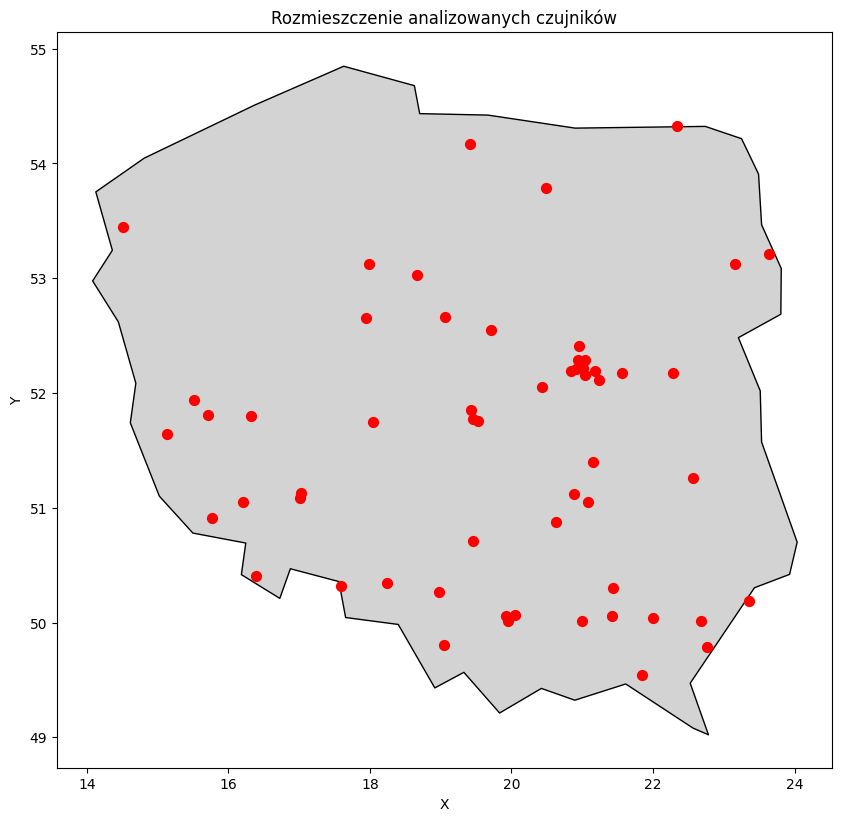

In [5]:
# Wizualizacja czujników

geometry = [Point(xy) for xy in zip(locs["Y"], locs["X"])]
gdf = gpd.GeoDataFrame(locs, geometry=geometry, crs="EPSG:4326")

poland_boundary = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
poland_boundary = poland_boundary[poland_boundary.name == "Poland"]

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect("equal")
poland_boundary.plot(ax=ax, color="lightgrey", edgecolor="black")
gdf.plot(ax=ax, color="red", markersize=50)
ax.set(title="Rozmieszczenie analizowanych czujników", xlabel="X", ylabel="Y")
plt.show()

In [6]:
df.describe()

,DsDusznikMOB,DsJaworMOB,DsJelGorOgin,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpMogiNowMOB,KpToruDziewu,KpWloclOkrze,LbLubObywate,...,SlBielPartyz,SlKatoKossut,SlZlotPotLes,WmElbBazynsk,WmGoldUzdrowMOB,WmOlsPuszkin,WpKaliSawick,ZpSzczAndr01,ZpSzczBudzWosMOB,ZpSzczPils02
count,8646.00000,8711.00000,8498.000,8707.0000,8646.0,7911.0000,8319.0000,7213.000,8713.000,8412.0,...,8740.000,8191.0000,8666.0000,7705.00000,8153.00000,8758.0000,8548.0,8665.0000,7140.0000,8735.00000
unique,8315.00000,8641.00000,8199.000,8630.0000,8119.0,1253.0000,1322.0000,1001.000,1315.000,1496.0,...,8280.000,8026.0000,8488.0000,7510.00000,8102.00000,8526.0000,8419.0,8596.0000,7108.0000,8406.00000
top,5.68639,8.91834,9.215,12.7177,6.4,11.7339,9.2328,7.363,11.297,11.7,...,16.461,26.2369,11.6497,8.66824,8.87476,7.5736,7.8,12.0078,12.4949,6.90583
freq,4.00000,2.00000,3.000,2.0000,23.0,45.0000,47.0000,49.000,42.000,41.0,...,8.000,4.0000,3.0000,3.00000,3.00000,4.0000,7.0,3.0000,2.0000,3.00000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2019-01-01 01:00:00 to 2020-01-01 00:00:00
Data columns (total 63 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DsDusznikMOB      8646 non-null   object
 1   DsJaworMOB        8711 non-null   object
 2   DsJelGorOgin      8498 non-null   object
 3   DsWrocAlWisn      8707 non-null   object
 4   DsWrocWybCon      8646 non-null   object
 5   KpBydPlPozna      7911 non-null   object
 6   KpMogiNowMOB      8319 non-null   object
 7   KpToruDziewu      7213 non-null   object
 8   KpWloclOkrze      8713 non-null   object
 9   LbLubObywate      8412 non-null   object
 10  LbNaleczow        8191 non-null   object
 11  LdLodzCzerni      8646 non-null   object
 12  LdLodzGdansk      8083 non-null   object
 13  LdZgieMielcz      8268 non-null   object
 14  LuNowaSolMOB      8164 non-null   object
 15  LuWsKaziWiel      8263 non-null   object
 16  LuZarySzyman      8496 n

In [8]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col])

### Obsługa NaNów

In [9]:
df.isna().sum().sort_values()[-10:]  # 8670

WmGoldUzdrowMOB      607
LuZielKrotka         622
PkHorZdrParkMOB      673
LdLodzGdansk         677
SkSkarZielnaMOB      801
KpBydPlPozna         849
WmElbBazynsk        1055
KpToruDziewu        1547
ZpSzczBudzWosMOB    1620
PmGdaLeczk08        4648
dtype: int64

In [10]:
# kolumna gdzie mamy 4648 wartości NaN, może zostać usunięta, gdyż jest to ponad połowa, a usuwając jedynie jeden czujnik nie tracimy zbyt wiele danych
# co więcej z póżniejszych analiz wyszło, że ZpSzczBudzWosMOB jest również problematyczny do uzupełnienia tak więc w tym momencie ta stacja również jest usuwana
df = df.drop(columns=["PmGdaLeczk08", "ZpSzczBudzWosMOB"])

In [11]:
def fill_missing_values(df):
    window_size = 168
    for column in df.columns:
        for i in range(len(df)):
            if pd.isnull(df.loc[df.index[i], column]):
                start_index = max(0, i - window_size)
                end_index = min(len(df), i + window_size)
                values_in_window = df.loc[df.index[start_index:end_index], column]
                non_null_values = values_in_window.dropna()
                if len(non_null_values) > 0:
                    df.loc[df.index[i], column] = non_null_values.mean()
    return df


df_filled = fill_missing_values(df)
df_filled.head()

,DsDusznikMOB,DsJaworMOB,DsJelGorOgin,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpMogiNowMOB,KpToruDziewu,KpWloclOkrze,LbLubObywate,...,SkStaraZlota,SlBielPartyz,SlKatoKossut,SlZlotPotLes,WmElbBazynsk,WmGoldUzdrowMOB,WmOlsPuszkin,WpKaliSawick,ZpSzczAndr01,ZpSzczPils02
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 01:00:00,33.40530,51.38780,118.7730,102.0900,107.0610,64.1177,NaN,24.0030,51.317,56.0910,...,28.46838,110.1990,76.7306,26.3444,34.3706,14.9449,40.9183,75.2000,9.869861,73.93500
2019-01-01 02:00:00,13.80280,28.49950,110.0640,63.6111,55.9187,43.8401,NaN,33.6542,30.698,25.9812,...,19.88634,73.4132,54.4664,19.0619,23.1494,10.7420,25.9358,47.9076,9.849110,11.78830
2019-01-01 03:00:00,9.94056,11.12060,107.9410,48.3540,41.3488,22.8383,NaN,13.6030,28.262,18.9462,...,16.89493,50.2355,50.4599,43.7717,21.0711,12.0391,24.5725,22.8309,5.570950,8.69917
2019-01-01 04:00:00,6.75889,5.57358,94.5489,34.6621,29.8697,20.1829,NaN,17.4302,26.522,17.9144,...,13.85738,37.5872,34.8090,64.0139,21.1671,13.1849,20.6336,20.5900,5.773690,5.96861
2019-01-01 05:00:00,7.88722,6.56224,67.8800,14.2870,17.6000,18.7345,NaN,23.0878,24.260,20.4470,...,10.45840,22.6446,30.6517,43.6111,21.0774,14.0005,19.4194,27.0838,6.154940,7.80778


In [12]:
na_cols = []
for col in df_filled.columns:
    if df_filled[col].isna().sum() != 0:
        print(col, df_filled[col].isna().sum())
        na_cols.append(col)

df_filled[na_cols]

KpMogiNowMOB 60
LbNaleczow 350


,KpMogiNowMOB,LbNaleczow
Date,,
2019-01-01 01:00:00,NaN,NaN
2019-01-01 02:00:00,NaN,NaN
2019-01-01 03:00:00,NaN,NaN
2019-01-01 04:00:00,NaN,NaN
2019-01-01 05:00:00,NaN,NaN
...,...,...
2019-12-31 20:00:00,12.0,5.42388
2019-12-31 21:00:00,8.9,5.25952
2019-12-31 22:00:00,8.5,5.17734


In [13]:
df_filled = df_filled.drop(columns=["KpMogiNowMOB", "LbNaleczow"])

In [14]:
df_filled.isna().sum().sum()  # sprawdzenie

0

### Tworzenie cech

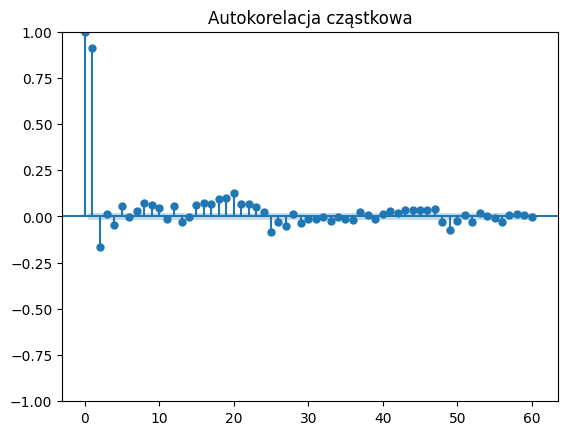

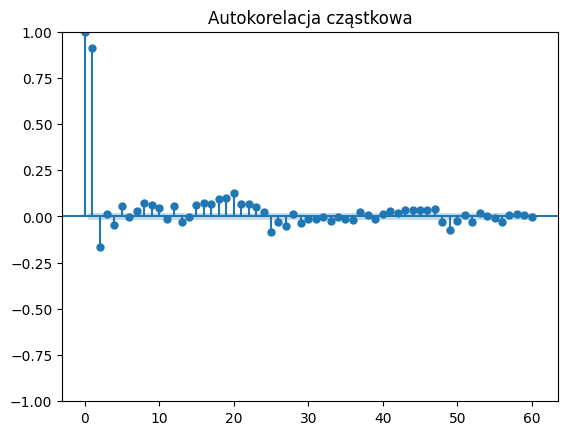

In [15]:
plot_pacf(df["DsDusznikMOB"], title="Autokorelacja cząstkowa", lags=60)

In [16]:
def create_features(df):
    lagged_features = pd.DataFrame()

    lag_hours = [1, 2, 24, 48]
    for lag_hour in lag_hours:
        shifted_df = df.shift(lag_hour)
        shifted_df.columns = [f"{col}_lag_{lag_hour}h" for col in df.columns]
        lagged_features = pd.concat([lagged_features, shifted_df], axis=1)

    df_with_features = pd.concat([df, lagged_features], axis=1)

    window_sizes = [
        24,
        168,
    ]  # Okna czasowe: 24 godziny (1 dzień) i 168 godzin (tydzień)
    for window_size in window_sizes:
        rolling_features = df.rolling(window=window_size).mean()
        df_with_features = pd.concat(
            [df_with_features, rolling_features.add_suffix(f"_rolling_{window_size}h")],
            axis=1,
        )

    df_with_features["hour"] = df_with_features.index.hour
    df_with_features["day_of_week"] = df_with_features.index.dayofweek
    df_with_features["month"] = df_with_features.index.month

    df_with_features["season"] = 0
    for date in df_with_features.index:
        month = date.month
        if 2 < month < 6:
            df_with_features.loc[date, "season"] = 1  # wiosna
        elif 5 < month < 9:
            df_with_features.loc[date, "season"] = 2  # lato
        elif 8 < month < 12:
            df_with_features.loc[date, "season"] = 3  # jesień
        else:
            df_with_features.loc[date, "season"] = 4  # zima

    return df_with_features


df_with_features = create_features(df_filled)

In [17]:
# czynnik przestrzenny - być może się przyda ?


def calculate_distances(df, locs):
    num_stations = len(locs)
    distance_matrix = pd.DataFrame(index=locs.index, columns=locs.index)

    for i in locs.index:
        for j in locs.index:
            if i == j:
                distance_matrix.loc[i, j] = 0.0
            else:
                coord_i = (locs.loc[i, "Y"], locs.loc[i, "X"])
                coord_j = (locs.loc[j, "Y"], locs.loc[j, "X"])
                distance_matrix.loc[i, j] = geodesic(coord_i, coord_j).kilometers

    return distance_matrix


distance_matrix = calculate_distances(df, locs)
print(distance_matrix.head())

Kod stacji   DsDusznikMOB DsJaworMOB DsJelGorOgin DsWrocAlWisn DsWrocWybCon  \
Kod stacji                                                                    
DsDusznikMOB          0.0  72.261741    88.383282   100.066391   104.688183   
DsJaworMOB      72.261741        0.0    50.463872    89.766786    91.911544   
DsJelGorOgin    88.383282  50.463872          0.0   139.234331   141.727927   
DsWrocAlWisn   100.066391  89.766786   139.234331          0.0     4.946732   
DsWrocWybCon   104.688183  91.911544   141.727927     4.946732          0.0   

Kod stacji   KpBydPlPozna KpMogiNowMOB KpToruDziewu KpWloclOkrze LbLubObywate  \
Kod stacji                                                                      
DsDusznikMOB   338.825453   295.249925   375.509078    379.86708   689.539025   
DsJaworMOB      296.14695   258.206307   344.333909   359.362388   705.136736   
DsJelGorOgin    340.36181   304.840168   391.975716   408.955894   753.994384   
DsWrocAlWisn   241.615496   196.412421   


W procesie tworzenia cech dla modelu predykcyjnego wykorzystano różnorodne podejścia, mające na celu uwzględnienie historii pomiarów pyłu PM2.5 oraz informacji związanych z czasem i przestrzenią.

1. **Cechy oparte na opóźnieniach wartości PM2.5:**  
   Stworzono cechy opóźnione o różne liczby godzin na podstawie autokorelacji (1h, 2h, 24h, 48h), co pozwala uwzględnić wpływ poprzednich pomiarów na aktualną wartość.

2. **Cechy oparte na oknach czasowych:**  
   Utworzono cechy oparte na średnich kroczących w oknach czasowych o długościach 24 i 168 godzin (odpowiednio 1 dzień i 1 tydzień).

3. **Cechy oparte na informacjach z datatime oraz oparte na sezonach:**  
   Utworzono cechy dotyczące informacji czasowych, takie jak godzina dnia, dzieńi  tygodni(rok jest wszędzie ten sam)esiąc i rok. Dodanie tych cech pozwala uwzględnić sezonowe oraz cykliczne wzorce w danych, co może mieć istotny wpływ na jakość predykcji. Dodatkowo, stworzono cechę określającą sezon roku (wiosna, lato, jesień, zima) na podstawie miesiąca.

Wszystkie powyższe cechy zostały wybrane z uwzględnieniem potrzeb modelu predykcyjnego oraz dostępnych danych. Wykorzystanie opóźnień, okien czasowych oraz informacji z datatime pozwal na uwzględniienie zarówno krótko- jak i długoterminowych wzorców w danych, co może znacząco poprawić jakość predykcji. Dodatkowo, uwzględnienie sezonów pozwala na adaptację modelu do zmieniających się warunków atmosferycznych w u roku.

### Uwzględnienie czynnika przestrzennego

W procesie tworzenia cech nie został bezpośrednio uwzględniony czynnik przestrzenny, czyli geograficzne położenie stacji pomiarowych. Jednakże, możliwe jest uwzględnienie tego czynnika poprzez analizę odległości między stacjami pomiarowymi oraz ich wzajemne oddziaływanie. Funkcja `calculate_distances` oblicza odległość między stacjami pomiarowymi, co może być wykorzystane do stworzenia dodatkowych cech uwzględniających przestrzenne zależności w danych.
leżności w danych.

### Podział zbioru danych oraz tworzenie wstępnych modeli do predykcji

In [18]:
models = {}  # słownik na modele dla każdej stacji

for station in [col for col in df_with_features.columns if col in locs.index]:
    station_features = [col for col in df_with_features.columns if station in col]
    station_features += ["hour", "day_of_week", "month", "season"]

    X_station = df_with_features[station_features]
    y_station = df_with_features[station]

    X_train_station, X_test_station, y_train_station, y_test_station = train_test_split(
        X_station, y_station, test_size=0.2, random_state=42, shuffle=False
    )  # shuffle False, bo chronologia

    xgb_model_station = XGBRegressor()
    xgb_model_station.fit(X_train_station, y_train_station)

    models[station] = xgb_model_station

Decyzja o tworzeniu modeli osobno dla każdej stacji wynika z faktu, że pomiary pyłu PM2.5 mogą być silnie zależne od lokalnych warunków środowiskowych, takich jak lokalizacja geograficzna, warunki atmosferyczne, rodzaj działalności przemysłowej, itp. Każda stacja pomiarowa może reprezentować unikalne warunki, dlatego też osobne modele dla poszczególnych stacji mogą lepiej odzwierciedlać te różnice i dostosować się do lokalnych wzorców zmienności pyłu PM2.5.

Tworzenie modeli indywidualnie dla każdej stacji umożliwia również dostosowanie hiperparametrów modelu do specyficznych cech danych pomiarowych dla danej lokalizacji. Ponadto, pozwala to na bardziej elastyczne zarządzanie danymi, takimi jak usuwanie lub dodawanie cech specyficznych dla danej stacji.

W rezultacie, decyzja o tworzeniu osobnych modeli dla każdej stacji pomiarowej pozwala na lepsze dopasowanie modeli do lokalnych warunków, co może poprawić jakość predykcji wartości pyłu PM2.5 dla poszczególnych stacji.

## Część 2 - Tworzenie modelu do predykcji

Plusy i minusy wykorzystania algorytmu XGBoost w kontekście predykcji szeregów czasowych

| Plusy                                                 | Minusy                                                  |
|-------------------------------------------------------|----------------------------------------------------------|
| Bardzo wysoka wydajność i skuteczność                 | Wrażliwość na overfitting, szczególnie w przypadku dużych zestawów danych |
| Możliwość obsługi różnorodnych typów danych           | Wymaga dobrego strojenia hiperparametrów                 |
| Elastyczność w obsłudze różnych funkcji straty       | Wymaga większej ilości danych w stosunku do innych algorytmów |
| Automatyczna obsługa brakujących wartości             | Skomplikowane interpretowanie wyników predykcji          |
| Wydajne przetwarzanie równoległe                      | Wymaga przetwarzania równoległego na wielu rdzeniach CPU/GPU |


### Tuning hiperparametrów

In [19]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
}
best_models = {}

for station in [col for col in df_with_features.columns if col in locs.index]:

    station_features = [col for col in df_with_features.columns if station in col]
    station_features += ["hour", "day_of_week", "month", "season"]

    X_station = df_with_features[station_features]
    y_station = df_with_features[station]
    X_train_station, X_test_station, y_train_station, y_test_station = train_test_split(
        X_station, y_station, test_size=0.2, random_state=42, shuffle=False
    )

    xgb_model_station = XGBRegressor()
    random_search_station = RandomizedSearchCV(
        estimator=xgb_model_station,
        param_distributions=param_grid,
        n_iter=50,
        cv=5,
        verbose=0,
        random_state=42,
        n_jobs=-1,
    )
    random_search_station.fit(X_train_station, y_train_station)

    print(
        "Najlepsze parametry dla stacji",
        station,
        ":",
        random_search_station.best_params_,
    )
    best_model_station = random_search_station.best_estimator_
    best_models[station] = best_model_station

Najlepsze parametry dla stacji DsDusznikMOB : {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Najlepsze parametry dla stacji DsJaworMOB : {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Najlepsze parametry dla stacji DsJelGorOgin : {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Najlepsze parametry dla stacji DsWrocAlWisn : {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Najlepsze parametry dla stacji DsWrocWybCon : {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Najlepsze parametry dla stacji KpBydPlPozna : {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Najlepsze parametry dla stacji KpToruDziewu : {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 3, 'lea

Hiperparametry są parametrami, które kontrolują proces uczenia się algorytmu uczenia maszynowego, ale nie są one bezpośrednio uczane z danymi treningowymi. W przeciwieństwie do parametrów modelu, które są uczane podczas procesu uczenia, hiperparametry muszą być ustalone przed rozpoczęciem procesu uczenia i mają wpływ na zachowanie i wydajność modelu.

Przykłady hiperparametrów obejmują:
- Liczbę drzew w modelach opartych na drzewach decyzyjnych (np. w algorytmie XGBoost)
- Maksymalną głębokość drzewa
- Szybkość uczenia (learning rate)
- Liczbę cech branych pod uwagę podczas budowy każdego drzewa
- Liczbę iteracji lub epok w algorytmach uczenia głębokiego


Tuning hiperparametrów jest procesem wybierania najlepszych wartości dla tych parametrów, które optymalizują wydajność i skuteczność modelu na danych treningowych oraz umożliwiają generalizację do danych testowych. Wymaga to eksperymentowania z różnymi zestawami wartości hiperparametrów i oceny wyników za pomocą odpowiednich metryk ewaluacyjnych. Tuning hiperparametrów ma na celu zbalansowanie pomiędzy nadmiernym dopasowaniem (overfitting) a niedopasowaniem (underfitting) modelu do danych treningowych oraz zapewnienie najlepszej możliwej wydajności modelu na nowych, nieznanych danych.

## Część 3 - Backtesting

### Podział na okna czasowe

In [20]:
tscv = TimeSeriesSplit(n_splits=5)

mse_scores = []

for train_index, test_index in tscv.split(df_with_features):
    X_train = df_with_features.iloc[train_index]
    X_test = df_with_features.iloc[test_index]

    for station, model in models.items():
        station_features = [col for col in X_train.columns if station in col]
        station_features += ["hour", "day_of_week", "month", "season"]

        X_train_station = X_train[station_features]
        X_test_station = X_test[station_features]
        y_train_station = X_train[station]
        y_test_station = X_test[station]

        y_pred_test_station = model.predict(X_test_station)

        mse_test_station = mean_squared_error(y_test_station, y_pred_test_station)
        mse_scores.append(mse_test_station)

mean_mse = np.mean(mse_scores)
print("Średni błąd średniokwadratowy dla wszystkich okien czasowych:", mean_mse)

Średni błąd średniokwadratowy dla wszystkich okien czasowych: 0.8698348577733466


Roll-Forward Validation

W tej metodologii:

- Tworzymy wiele okien czasowych, gdzie każde kolejne okno jest przesunięciem w przyszłość względem poprzedniego okna.
- Model jest trenowany na danych historycznych do momentu, w którym kończy się dane w danym oknie czasowym.
- Następnie model jest testowany na danych z kolejnego okna czasowego.
- Ten proces jest powtarzany dla każdego okna czasowego, a wyniki są zbierane i oceniane, aby zrozumieć wydajność modelu na przyszłych danych.

Głównym celem tego sposobu walidacji jest uzyskanie rzeczywistej oceny wydajności modelu na przyszłych danych. W przeciwieństwie do tradycyjnego podziału na zbiór treningowy i testowy, gdzie dane testowe są zwykle wyznaczone na końcu zbioru danych, walidacja za pomocą okien czasowych pozwala na ocenę modelu na danych, które są bardziej zbliżone do tych, które zostaną napotkane w przyszłości. Jest to szczególnie istotne w przypadku szeregów czasowych, gdzie zależy nam na przewidywaniu przyszłych wartości na podstawie historii. Dlatego właśnie ten sposób walidacji jest często stosowany w analizie szeregów czasowych.

### Ocena wydajności

In [21]:
mse_scores_per_station = {}

for station, model in best_models.items():
    station_features = [col for col in df_with_features.columns if station in col]
    station_features += ["hour", "day_of_week", "month", "season"]

    X_station = df_with_features[station_features]
    y_station = df_with_features[station]
    X_train_station, X_test_station, y_train_station, y_test_station = train_test_split(
        X_station, y_station, test_size=0.2, random_state=42, shuffle=False
    )
    y_pred_test_station = model.predict(X_test_station)
    mse_test_station = mean_squared_error(y_test_station, y_pred_test_station)
    mse_scores_per_station[station] = mse_test_station

for station, mse in mse_scores_per_station.items():
    print("Błąd średniokwadratowy dla stacji", station, ":", mse)

Błąd średniokwadratowy dla stacji DsDusznikMOB : 1.345556432903394
Błąd średniokwadratowy dla stacji DsJaworMOB : 0.6696523209490601
Błąd średniokwadratowy dla stacji DsJelGorOgin : 0.9608649061639052
Błąd średniokwadratowy dla stacji DsWrocAlWisn : 0.2660882376642321
Błąd średniokwadratowy dla stacji DsWrocWybCon : 0.15753398066628774
Błąd średniokwadratowy dla stacji KpBydPlPozna : 4.574708874529287
Błąd średniokwadratowy dla stacji KpToruDziewu : 0.4468912396635128
Błąd średniokwadratowy dla stacji KpWloclOkrze : 15.914220974175265
Błąd średniokwadratowy dla stacji LbLubObywate : 7.145174240833071
Błąd średniokwadratowy dla stacji LdLodzCzerni : 0.005198768939541813
Błąd średniokwadratowy dla stacji LdLodzGdansk : 15.508351070420604
Błąd średniokwadratowy dla stacji LdZgieMielcz : 8.352345113289637
Błąd średniokwadratowy dla stacji LuNowaSolMOB : 12.663832307555387
Błąd średniokwadratowy dla stacji LuWsKaziWiel : 11.81907820695338
Błąd średniokwadratowy dla stacji LuZarySzyman : 2.9


1. **Wariancja błędów w pomiarach**: Błędy średniokwadratowe (MSE) różnią się znacząco między różnymi stacjami pomiarowymi. Na przykład, stacja DsWrocAlWisn ma stosunkowo niski błąd MSE wynoszący 0.27, podczas gdy stacja MzLegZegrzyn ma wysoki błąd MSE na poziomie 25.96. To sugeruje, że niektóre stacje mają lepszą dokładność w pomiarach niż inne.

2. **Zróżnicowanie jakości danych**: Błędy MSE mogą odzwierciedlać różnice w jakości danych między różnymi stacjami. Stacje o niższych błędach MSE mogą być lepiej skonfigurowane, lepiej utrzymane lub znajdować się w miejscach, gdzie pomiary są łatwiejsze do przeprowadzenia. Stacje o wyższych błędach MSE mogą mieć problemy techniczne, być niewłaściwie kalibrowane lub znajdować się w miejscach, gdzie warunki pomiarowe są trudniejsze.

3. **Wartość odniesienia**: Stacje z bardzo niskimi błędami MSE, takie jak LdLodzCzerni (0.005) i SlZlotPotLes (0.027), sugerują, że pomiary na tych stacjach są bardzo dokładne i mogą być używane jako punkty odniesienia do porównywania dokładności innych pomiarów.


### Backtesting modelu:

Backtesting to metoda oceny wydajności modelu na danych historycznych, które nie zostały użyte do trenowania. Jest to często stosowana praktyka w finansach i inwestycjach, gdzie model jest testowany na danych historycznych, aby sprawdzić, jak dobrze działa na przeszłych danych. W przypadku analizy szeregów czasowych backtesting pozwala na ocenę, jak dobrze model radzi sobie z przewidywaniem przyszłych wartości na podstawie danych historycznyc
h.
### Różnica między backtestingiem a testowaniem na danych niebędących szeregami czasowymi:

Backtesting ma na celu ocenę wydajności modelu na danych historycznych, które są zorganizowane w szereg czasowy, aby sprawdzić jego zdolność do przewidywania przyszłych wartości na podstawie przeszłych danych.

Testowanie wydajności modelu dla danych niebędących szeregami czasowymi może obejmować różne typy danych, ale zazwyczaj nie są one zorganizowane w szereg czasowy. Celem jest zwykle sprawdzenie ogólnej zdolności modelu do generalizacji na nowe, nieznane dane, bez uwzględniania ich sekwencyjnej struktury czaasowej.

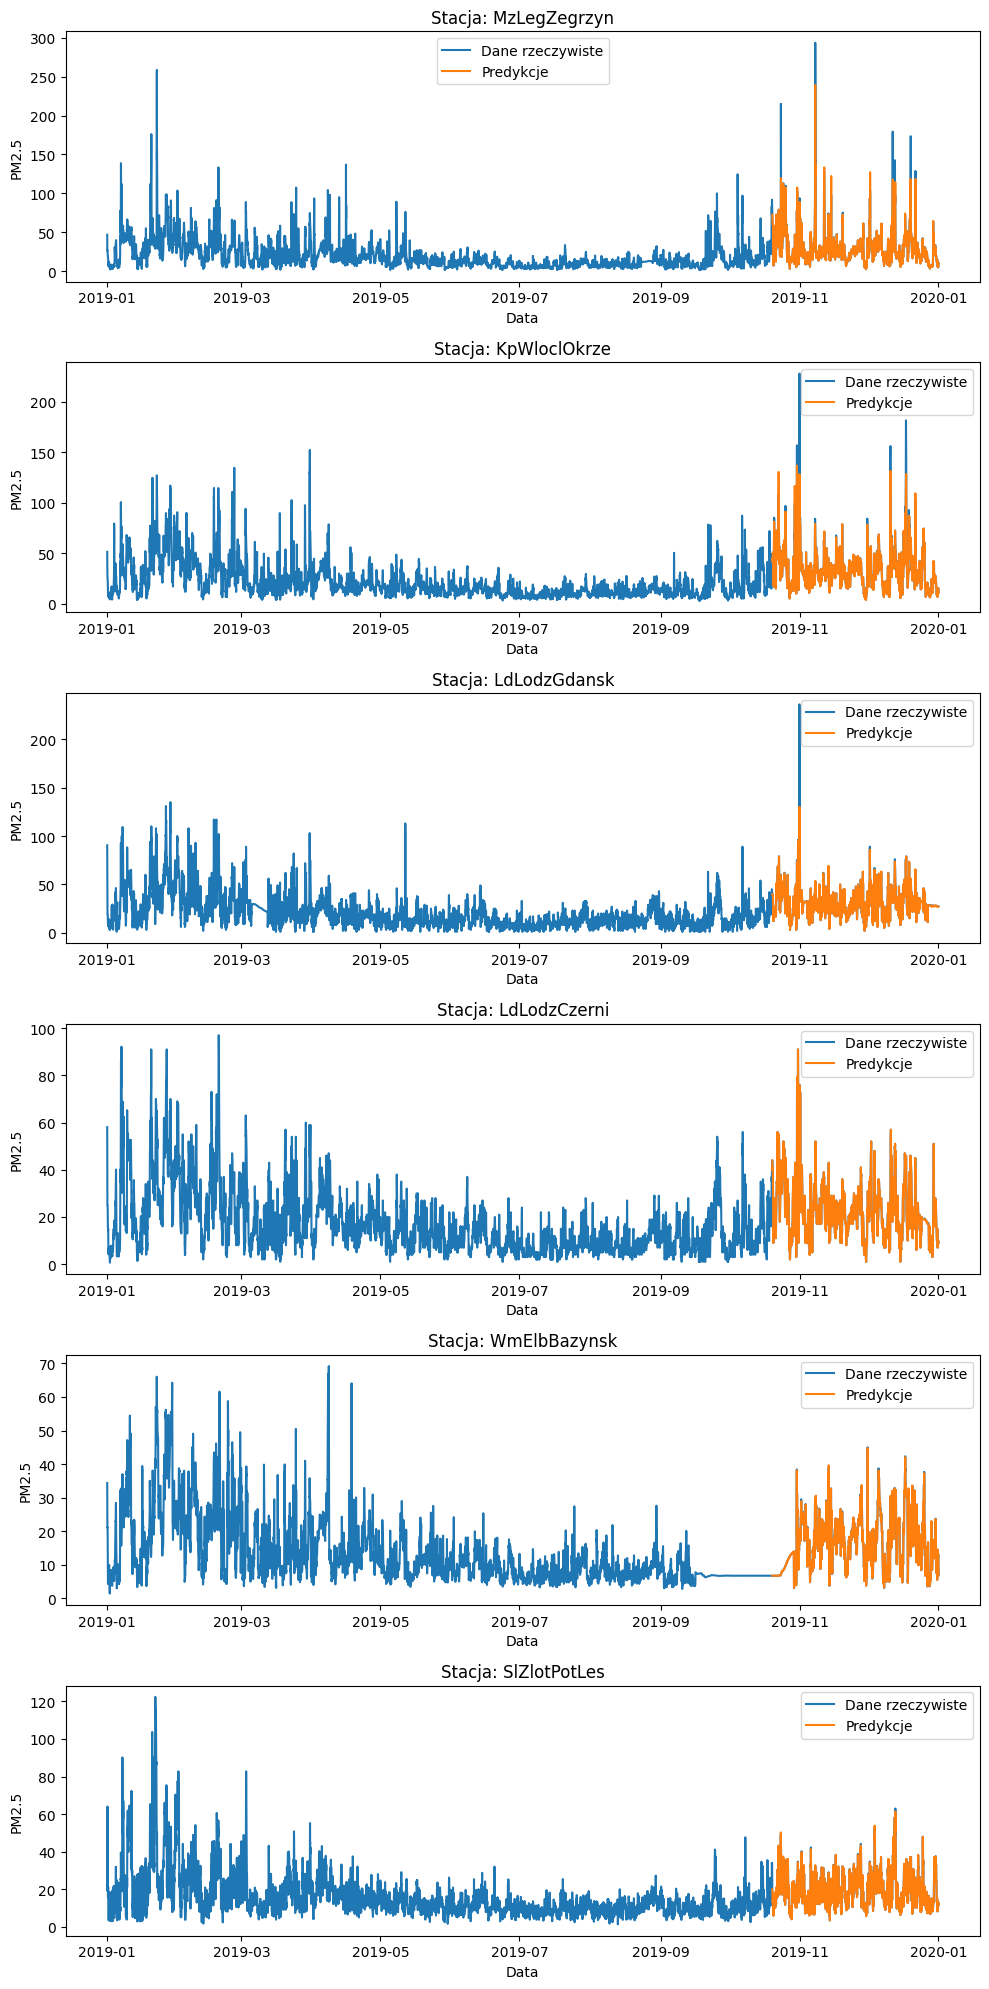

In [26]:
highest_mse_stations = sorted(
    mse_scores_per_station, key=mse_scores_per_station.get, reverse=True
)[
    :3
]  # trzy stacje z najwyźszym MSE
lowest_mse_stations = sorted(mse_scores_per_station, key=mse_scores_per_station.get)[
    :3
]  # trzy stacje z najniższym MSE
sorted_stations = (
    highest_mse_stations + lowest_mse_stations
)  # sorted(mse_scores_per_station, key=mse_scores_per_station.get)[:6]

fig, axs = plt.subplots(6, 1, figsize=(10, 20))
axs = axs.ravel()

for i, station in enumerate(sorted_stations):
    station_features = [col for col in df_with_features.columns if station in col]
    station_features += ["hour", "day_of_week", "month", "season"]

    X_station = df_with_features[station_features]
    y_station = df_with_features[station]

    X_train_station, X_test_station, y_train_station, y_test_station = train_test_split(
        X_station, y_station, test_size=0.2, random_state=42, shuffle=False
    )

    y_pred_test_station = best_models[station].predict(X_test_station)

    axs[i].plot(y_station.index, y_station, label="Dane rzeczywiste")
    axs[i].plot(y_test_station.index, y_pred_test_station, label="Predykcje")
    axs[i].set_title(f"Stacja: {station}")
    axs[i].set_xlabel("Data")
    axs[i].set_ylabel("PM2.5")
    axs[i].legend()

plt.tight_layout()
plt.show()

Powyższy kod generuje wykresy, na których porównywane są rzeczywiste i przewidywane wartości PM2.5 dla trzech stacji z najwyższym oraz trzech stacji z najniższym błędem średniokwadratowym (MSE). Stacje zostały wybrane na podstawie wyników MSE dla każdej stacji. Widać, że dla najgorszych wyników predykcje nie pokrywają się z prawdziwymi wartościami, zwłaszcza na pikach, a dla top 3 predykcje wyglądają praktycznie jak wartości rzeczywiste. Mimo wszystko nawet najgorsze 3 modele pod względem MSE nie wyglądają źle - można predykować PM2.5 przy użyciu stworzonych modeli dla każdej ze stacji.


## Część 4 - Analiza istotności cech

In [23]:
importances = {}

for station, model in best_models.items():
    station_features = [col for col in df_with_features.columns if station in col]
    station_features += ["hour", "day_of_week", "month", "season"]
    importances[station] = model.feature_importances_

In [24]:
feature_importances_with_names = {}

for station, importances_array in importances.items():
    station_features = [col for col in df_with_features.columns if station in col]
    station_features += ["hour", "day_of_week", "month", "season"]
    features_with_importance = [
        (feature, importance)
        for feature, importance in zip(station_features, importances_array)
    ]
    feature_importances_with_names[station] = features_with_importance

print(feature_importances_with_names)

{'DsDusznikMOB': [('DsDusznikMOB', 0.94675136), ('DsDusznikMOB_lag_1h', 0.006143732), ('DsDusznikMOB_lag_2h', 0.003886389), ('DsDusznikMOB_lag_24h', 0.008530299), ('DsDusznikMOB_lag_48h', 0.004096906), ('DsDusznikMOB_rolling_24h', 0.007176677), ('DsDusznikMOB_rolling_168h', 0.0049393685), ('hour', 0.00808442), ('day_of_week', 0.010390798), ('month', 0.0), ('season', 0.0)], 'DsJaworMOB': [('DsJaworMOB', 0.79871464), ('DsJaworMOB_lag_1h', 0.018121867), ('DsJaworMOB_lag_2h', 0.008997144), ('DsJaworMOB_lag_24h', 0.010596619), ('DsJaworMOB_lag_48h', 0.011284), ('DsJaworMOB_rolling_24h', 0.012860041), ('DsJaworMOB_rolling_168h', 0.009522753), ('hour', 0.021761505), ('day_of_week', 0.07960955), ('month', 0.0076776496), ('season', 0.020854177)], 'DsJelGorOgin': [('DsJelGorOgin', 0.9792649), ('DsJelGorOgin_lag_1h', 0.0026700606), ('DsJelGorOgin_lag_2h', 0.0008370778), ('DsJelGorOgin_lag_24h', 0.0017308359), ('DsJelGorOgin_lag_48h', 0.0032570376), ('DsJelGorOgin_rolling_24h', 0.006459928), ('DsJ

In [25]:
total_importance_by_feature_type = defaultdict(float)
count_by_feature_type = defaultdict(int)
desired_feature_types = [
    "lag_1h",
    "lag_2h",
    "lag_24h",
    "lag_48h",
    "rolling_24h",
    "rolling_168h",
    "hour",
    "day_of_week",
    "month",
    "season",
]

for features_with_importance in feature_importances_with_names.values():
    for feature, importance in features_with_importance:
        for desired_feature_type in desired_feature_types:
            if desired_feature_type in feature:
                total_importance_by_feature_type[desired_feature_type] += importance
                count_by_feature_type[desired_feature_type] += 1
                break
        else:
            total_importance_by_feature_type["PM2.5"] += importance
            count_by_feature_type["PM2.5"] += 1

average_importance_by_feature_type = {}

for feature_type in desired_feature_types:
    if count_by_feature_type[feature_type] != 0:
        average_importance_by_feature_type[feature_type] = (
            total_importance_by_feature_type[feature_type]
            / count_by_feature_type[feature_type]
        )
    else:
        average_importance_by_feature_type[feature_type] = 0

for station_name, total_importance in total_importance_by_feature_type.items():
    count = count_by_feature_type[station_name]
    if count != 0:
        average_importance_by_feature_type[station_name] = total_importance / count
    else:
        average_importance_by_feature_type[station_name] = 0

sorted_feature_types = sorted(
    average_importance_by_feature_type.items(), key=lambda x: x[1], reverse=True
)

for feature_type, average_importance in sorted_feature_types:
    print(
        f"Typ cechy: {feature_type}, Średnia wartość istotności: {average_importance}"
    )

Typ cechy: PM2.5, Średnia wartość istotności: 0.9125722234899347
Typ cechy: lag_1h, Średnia wartość istotności: 0.03452801036537081
Typ cechy: day_of_week, Średnia wartość istotności: 0.008178778545475945
Typ cechy: rolling_168h, Średnia wartość istotności: 0.007340613687611866
Typ cechy: hour, Średnia wartość istotności: 0.007221069098436187
Typ cechy: rolling_24h, Średnia wartość istotności: 0.006443819623039169
Typ cechy: lag_24h, Średnia wartość istotności: 0.006279724748512969
Typ cechy: month, Średnia wartość istotności: 0.0062091026859356835
Typ cechy: lag_48h, Średnia wartość istotności: 0.005964279956201195
Typ cechy: lag_2h, Średnia wartość istotności: 0.003599519710976231
Typ cechy: season, Średnia wartość istotności: 0.0016628517396177565


**Wartości istotności cech w modelu XGBoost** określają, jak bardzo poszczególne cechy przyczyniają się do predykcji docelowej zmiennej (w tym przypadku poziomu pyłu PM2.5). Im wyższa wartość istotności cechy, tym większy wpływ ma ona na predykcję. W praktyce istotność cech może być wykorzystana do selekcji cech, redukcji wymiarowości danych lub lepszego zrozumienia procesów zachodzących w modelu. Na podstawie istotności cech możemy podejmować decyzje dotyczące optymalizacji modelu lub dalszych działań analitycznych.

**Interpretacja wyników:**

- **PM2.5:** Najważniejsza cecha - poziom PM2.5 dla danej stacji bez żadnych obróbek.
- **lag_1h:** Opóźnienie o jedną godzinę - istotne, ale mniej ważne niż PM2.5.
- **day_of_week:** Dzień tygodnia - mały wpływ na predykcje w porównaniu do innych cech.
- **lag_24h:** Opóźnienie o 24 godziny - ważne, ale mniej istotne niż lag_1h.
- **hour:** Godzina dnia - niewielki wpływ na predykcje.
- **rolling_168h:** Średnia krocząca z ostatnich 168 godzin - istotne, ale mniej ważne niż opóźnienia czasowe.

Ogólnie rzecz biorąc dane PM2.5 mają największy wpływ na predykcje, a opóźnienia czasowe (lag_1h, lag_24h) również są istotne. Dni tygodnia, godziny oraz sezon mają mniejsze znaczenie.

## Podsumowanie 

Projekt miał na celu zastosowanie modelu XGBoost do przewidywania poziomu pyłu PM2.5 na podstawie danych z wielu stacji pomiarowych. Realizacja:

1. **Przygotowanie danych:**
   - Dane zostały poddane analizie wstępnej, która obejmowała usuwanie brakujących wartości i wybór odpowiednich cech do modelowania.

2. **Trenowanie modelu:**
   - Wykorzystano model XGBoost, który jest popularnym modelem do regresji i klasyfikacji w przypadku dużych zbiorów danych.
   - Model został wytrenowany na danych treningowych, a następnie oceniony na zbiorze testowym.

3. **Ocena modelu:**
   - Do oceny wydajności modelu wykorzystano metrykę Mean Squared Error (MSE).
   - Przeprowadzono również backtesting, czyli testowanie modelu na danych historycznych, aby zweryfikować jego skuteczność w przewidywaniu przyszłych wartości.

4. **Analiza istotności cech:**
   - Przeprowadzono analizę istotności cech, aby zidentyfikować najważniejsze czynniki wpływające na predykcję poziomu pyłu PM2.5.
   - W wyniku analizy stwierdzono, że najważniejszą cechą jest historyczne PM2.5.

5. **Podsumowanie i wnioski:**
   - Projekt pozwolił na skuteczne przewidywanie poziomu pyłu PM2.5 na podstawie danych z wielu stacji pomiarowych.
   - Istotność cech pozwoliła zidentyfikować kluczowe czynniki wpływające na predykcje.
   - Wyniki projektu mogą być wykorzystane do podejmowania decyzji dotyczących monitorowania jakości powietrza i podejmowania działań w celu jej poprawy.

